In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load data
df = pd.read_csv(r'C:\Users\dinhn\Downloads\Ethereum_Historical_Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

# Split data into train and test sets
train_size = int(0.8 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

Epoch 1/100
48/48 [==============================] - 5s 11ms/step - loss: 0.0149
Epoch 2/100
48/48 [==============================] - 1s 11ms/step - loss: 7.6116e-04
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 6.6406e-04
Epoch 4/100
48/48 [==============================] - 1s 13ms/step - loss: 6.4602e-04
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 6.1437e-04
Epoch 6/100
48/48 [==============================] - 1s 11ms/step - loss: 5.6318e-04
Epoch 7/100
48/48 [==============================] - 1s 11ms/step - loss: 5.2846e-04
Epoch 8/100
48/48 [==============================] - 0s 10ms/step - loss: 5.6453e-04
Epoch 9/100
48/48 [==============================] - 1s 16ms/step - loss: 5.0394e-04
Epoch 10/100
48/48 [==============================] - 1s 11ms/step - loss: 4.6201e-04
Epoch 11/100
48/48 [==============================] - 1s 11ms/step - loss: 4.7827e-04
Epoch 12/100
48/48 [==============================] - 1s 12ms/step 

<h2> Predict Price for next 30 days </h2>

Predicted Ethereum prices for the next 30 days:
[3825.90491484 3838.14584156 3850.41114311 3862.06343174 3873.36606766
 3884.37984785 3895.13727209 3905.63946106 3915.88557425 3925.87365046
 3935.62078009 3945.13032518 3954.4064883  3963.45431252 3972.2777202
 3980.88091393 3989.26725573 3997.44206884 4005.40871532 4013.17223824
 4020.73627979 4028.10504255 4035.28328941 4042.27382208 4049.08140345
 4055.70967573 4062.16312166 4068.44454294 4074.55926281 4080.51008297]


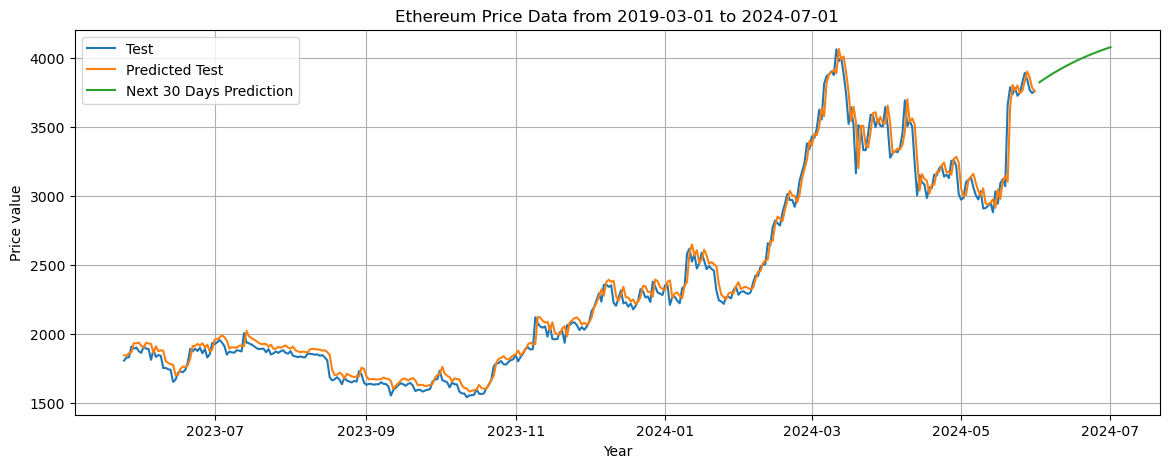

In [2]:
# The process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 90 days
print('Predicted Ethereum prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 30 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predicted Price for next 60 days


Predicted Ethereum prices for the next 60 days:
[3825.90491484 3838.14584156 3850.41114311 3862.06343174 3873.36606766
 3884.37984785 3895.13727209 3905.63946106 3915.88557425 3925.87365046
 3935.62078009 3945.13032518 3954.4064883  3963.45431252 3972.2777202
 3980.88091393 3989.26725573 3997.44206884 4005.40871532 4013.17223824
 4020.73627979 4028.10504255 4035.28328941 4042.27382208 4049.08140345
 4055.70967573 4062.16312166 4068.44454294 4074.55926281 4080.51008297
 4086.30064564 4091.93543354 4097.41752855 4102.75057289 4107.93848894
 4112.98351807 4117.89126368 4122.66340679 4127.30358963 4131.8146139
 4136.19984163 4140.46291506 4144.60691605 4148.63576698 4152.55114889
 4156.35586348 4160.05299261 4163.645338   4167.13570135 4170.52744471
 4173.82196892 4177.02179552 4180.13000639 4183.14912306 4186.08250757
 4188.93100044 4191.69796371 4194.3842379  4196.99290487 4199.526206  ]


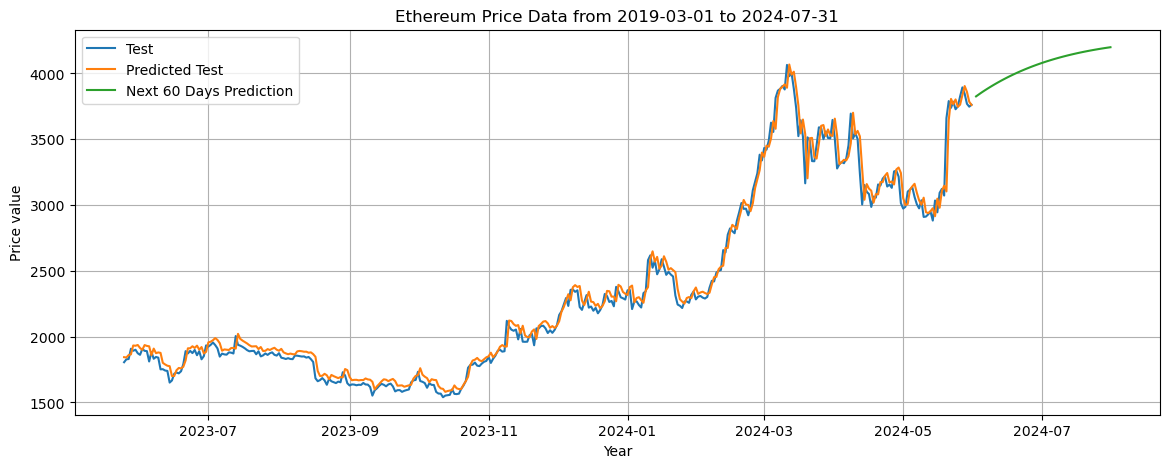

In [3]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted Ethereum prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predict Price for the next 90 days </h2>

Predicted Ethereum prices for the next 90 days:
[3825.90491484 3838.14584156 3850.41114311 3862.06343174 3873.36606766
 3884.37984785 3895.13727209 3905.63946106 3915.88557425 3925.87365046
 3935.62078009 3945.13032518 3954.4064883  3963.45431252 3972.2777202
 3980.88091393 3989.26725573 3997.44206884 4005.40871532 4013.17223824
 4020.73627979 4028.10504255 4035.28328941 4042.27382208 4049.08140345
 4055.70967573 4062.16312166 4068.44454294 4074.55926281 4080.51008297
 4086.30064564 4091.93543354 4097.41752855 4102.75057289 4107.93848894
 4112.98351807 4117.89126368 4122.66340679 4127.30358963 4131.8146139
 4136.19984163 4140.46291506 4144.60691605 4148.63576698 4152.55114889
 4156.35586348 4160.05299261 4163.645338   4167.13570135 4170.52744471
 4173.82196892 4177.02179552 4180.13000639 4183.14912306 4186.08250757
 4188.93100044 4191.69796371 4194.3842379  4196.99290487 4199.526206
 4201.9858223  4204.37343479 4206.69100468 4208.94273451 4211.12806395
 4213.24951452 4215.30764658 4217

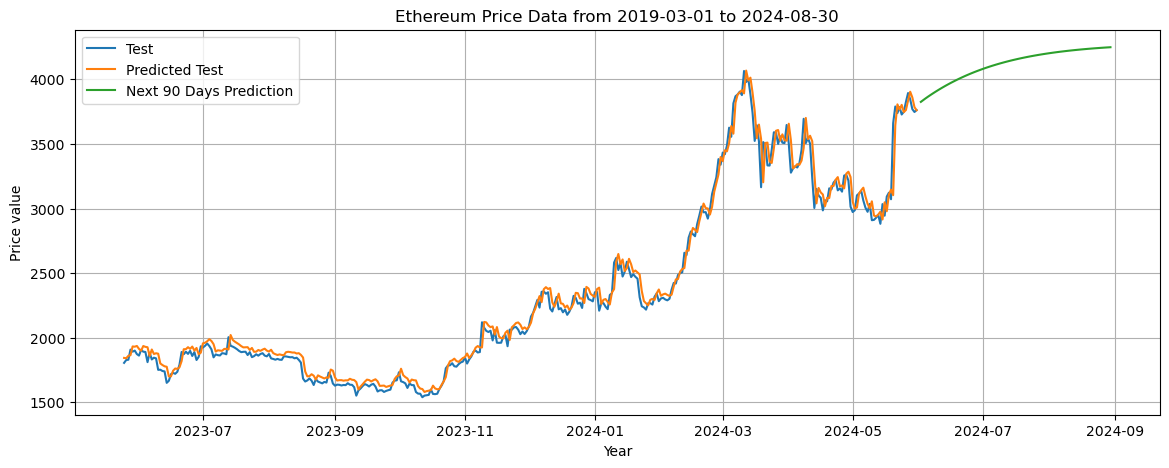

In [4]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted Ethereum prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()